In [1]:
import skimage
import skimage.io
import matplotlib.pyplot as plt
import os
import numpy as np
import skimage.morphology
from skimage import img_as_bool
from tqdm import tqdm

In [2]:
mock = "/media/malou/Seagate Expansion Drive/Malou_Master/Master/data/Large_prediction/mock/ch0/"
mockpred = "/media/malou/Seagate Expansion Drive/Malou_Master/Master/data/Large_prediction/mockpred/"
mocklist = os.listdir(mockpred)

testset = mocklist[0:30]

In [3]:
def pred_to_label(pred, cell_min_size, cell_label=1):
    # Only marks interior of cells (cell_label = 1 is interior, cell_label = 2 is boundary)
    cell=(pred == cell_label)
    # fix cells
    cell = skimage.morphology.remove_small_holes(cell, area_threshold=500)
    cell = skimage.morphology.remove_small_objects(cell, min_size=cell_min_size)
    
    # label cells only
    [label, num] = skimage.morphology.label(cell, return_num=True)
    return label

def probmap_to_pred(probmap, boundary_boost_factor):
    # we need to boost the boundary class to make it more visible
    # this shrinks the cells a little bit but avoids undersegmentation
    pred = np.argmax(probmap * [1, 1, boundary_boost_factor], -1)
    
    return pred

def get_nuclei_intensity(img, annot):
    annot_bool = np.zeros(annot.shape)
    annot_bool[annot>0] = True
    annot_bool = img_as_bool(annot_bool)
    newim = img.copy()
    newim[annot_bool==False] = 0
    pixels, value = np.unique(newim, return_counts = True)
    val = 0
    for i,pixel in enumerate(pixels):
        val += pixel*value[i]
    avg_intensity = val/sum(value[1:])
    return(avg_intensity)

def normalize(orig_img):

    percentile = 99.9
    high = np.percentile(orig_img, percentile)
    low = np.percentile(orig_img, 100-percentile)

    img = np.minimum(high, orig_img)
    img = np.maximum(low, img)

    img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
    
    img = skimage.img_as_ubyte(img)
    return(img)


/home/malou/Master/master-env/lib/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/home/malou/Master/master-env/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


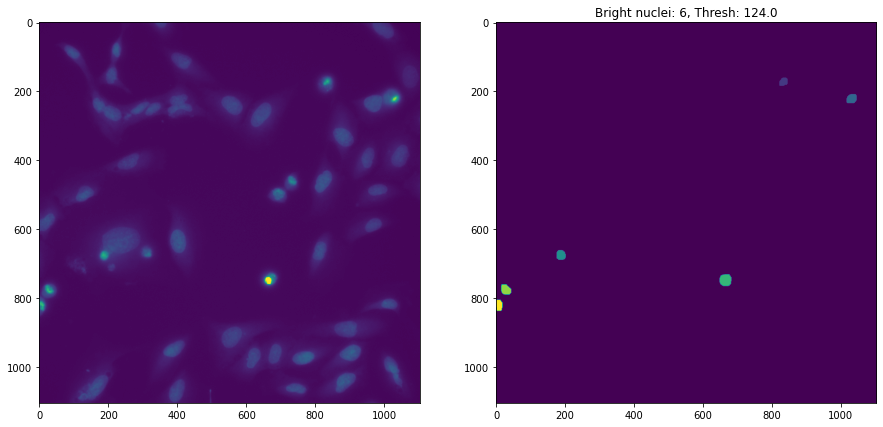

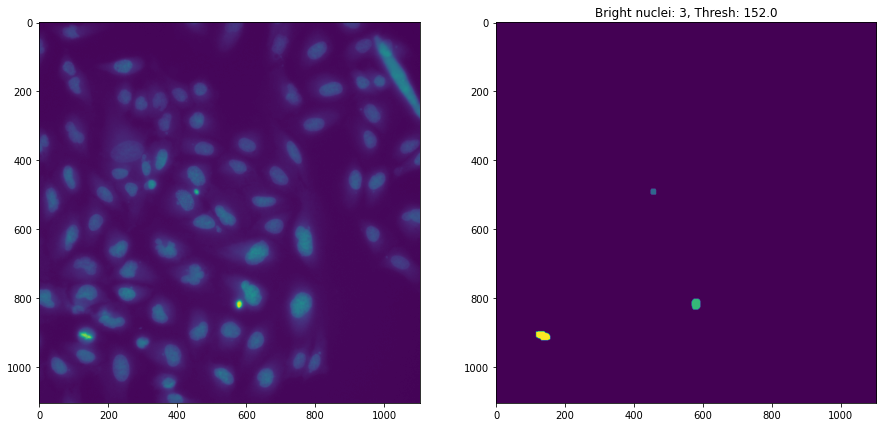

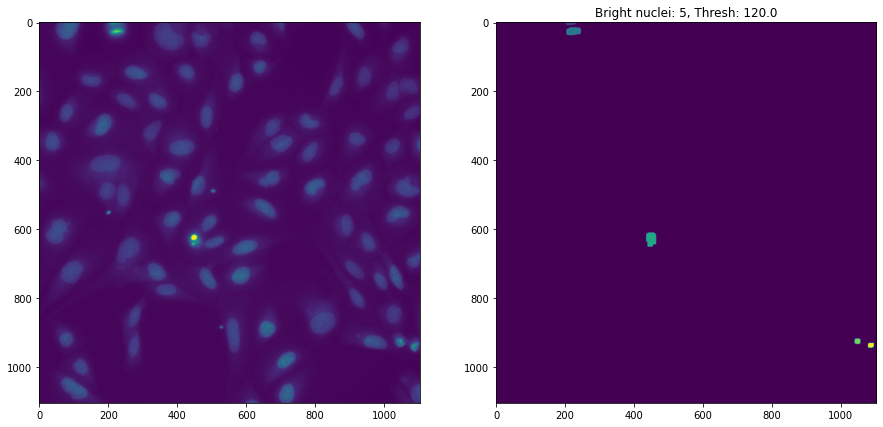

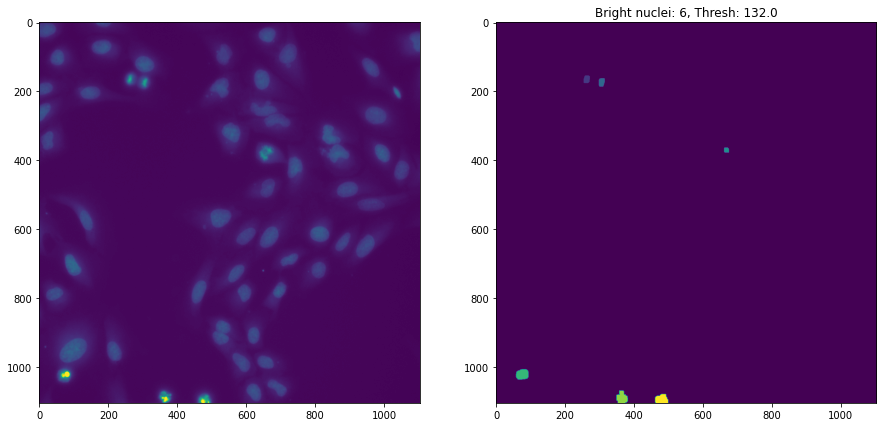

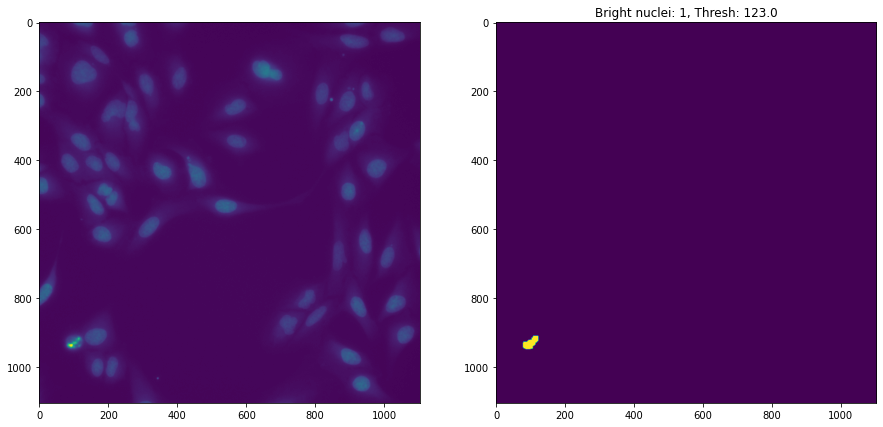

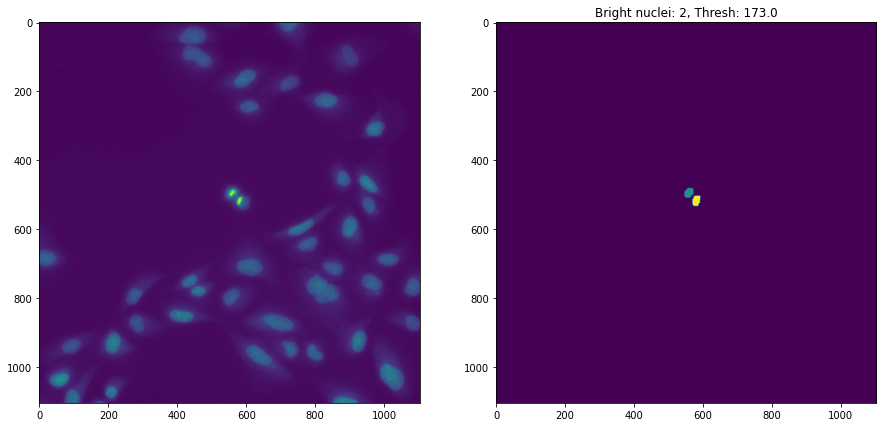

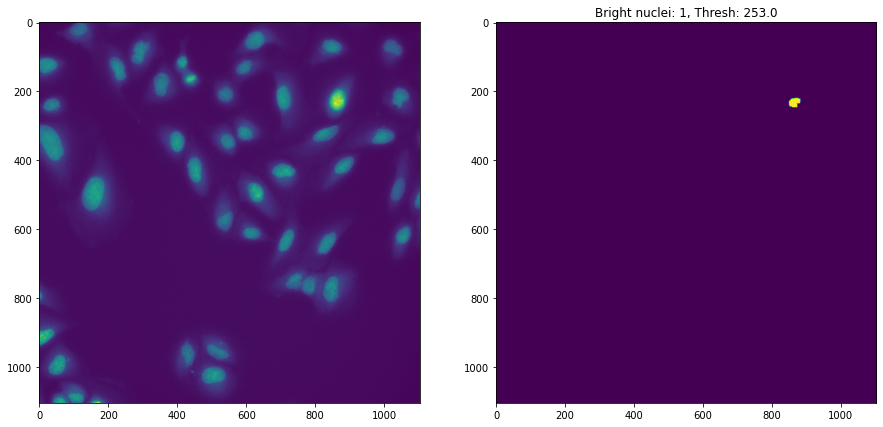

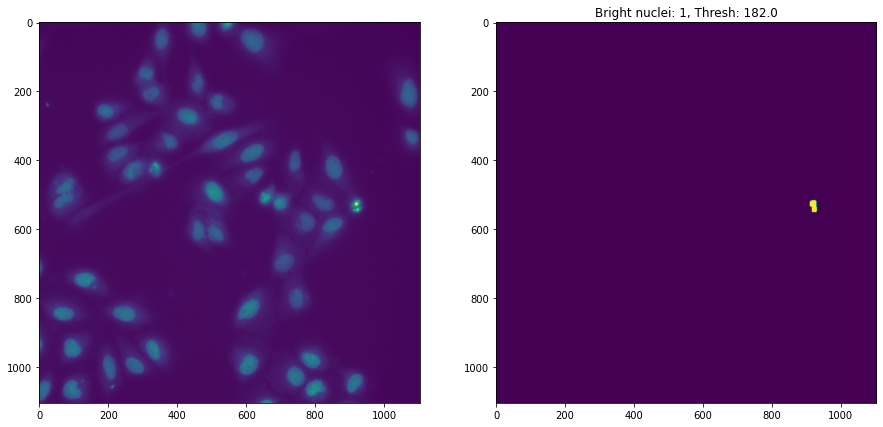

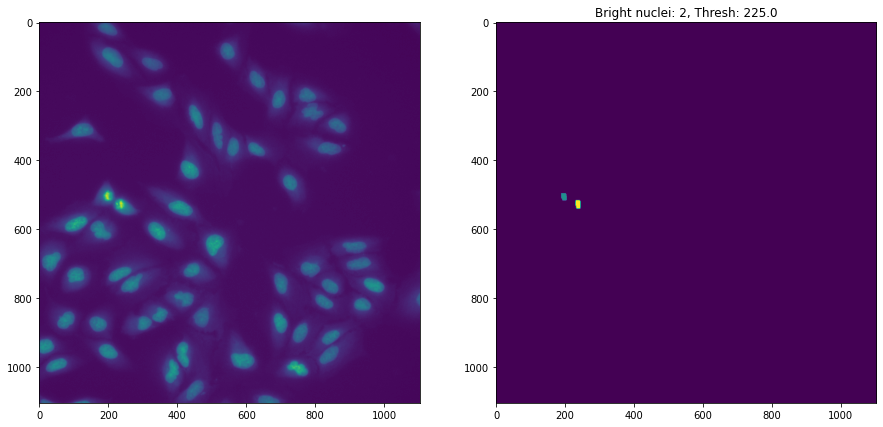

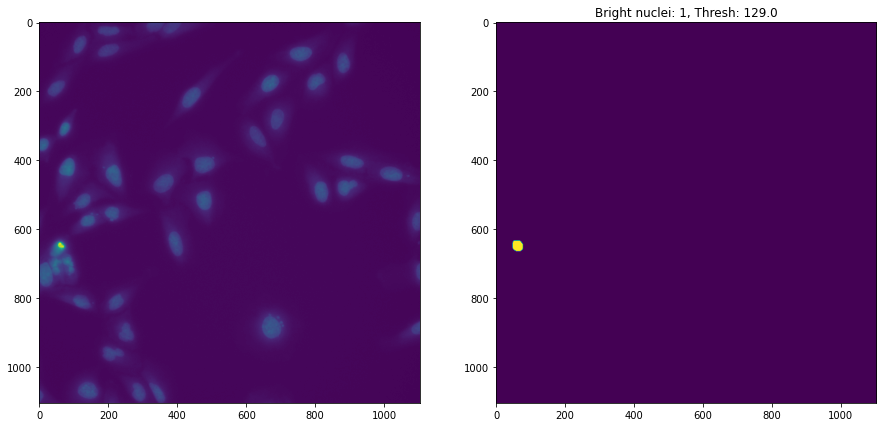

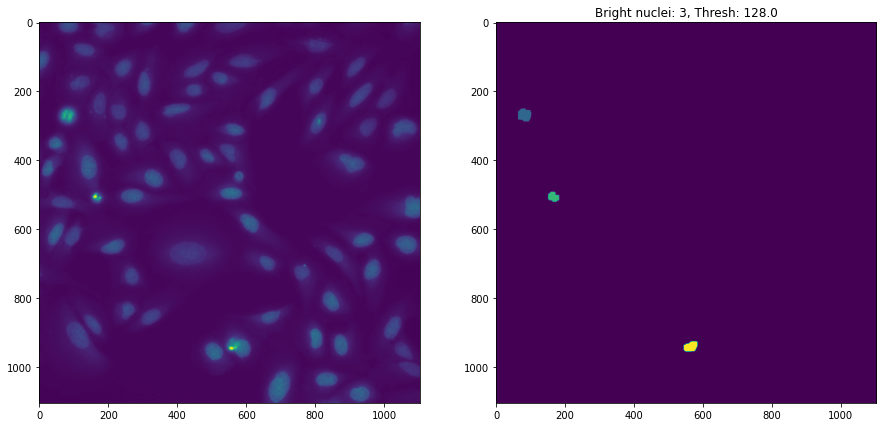

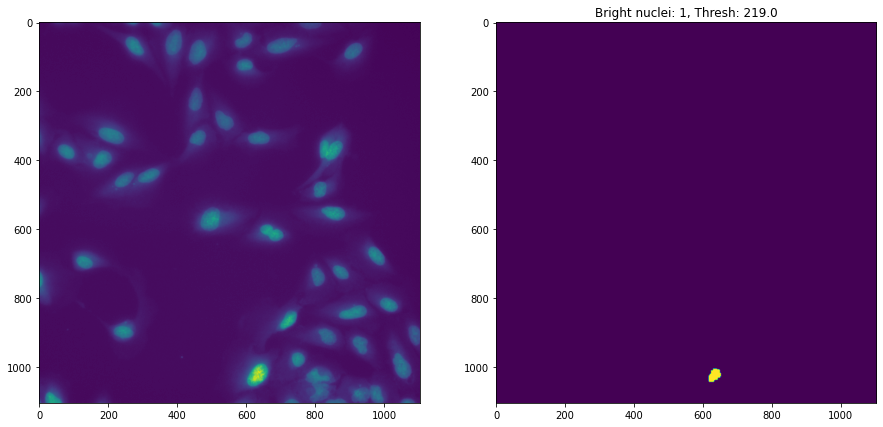

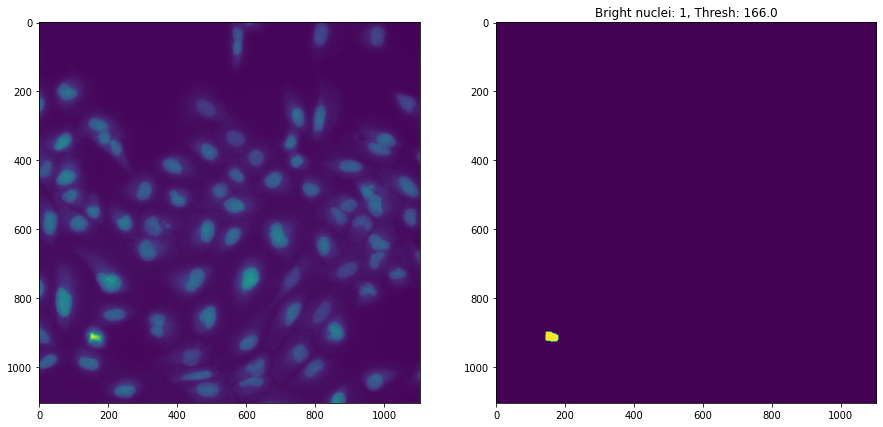

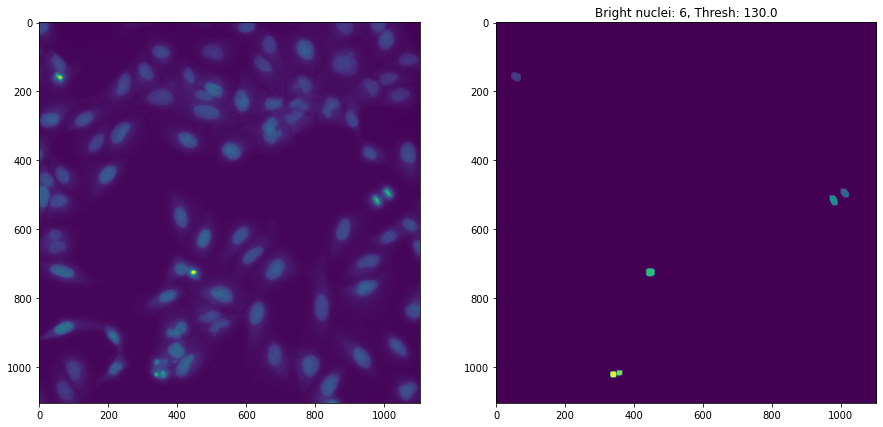

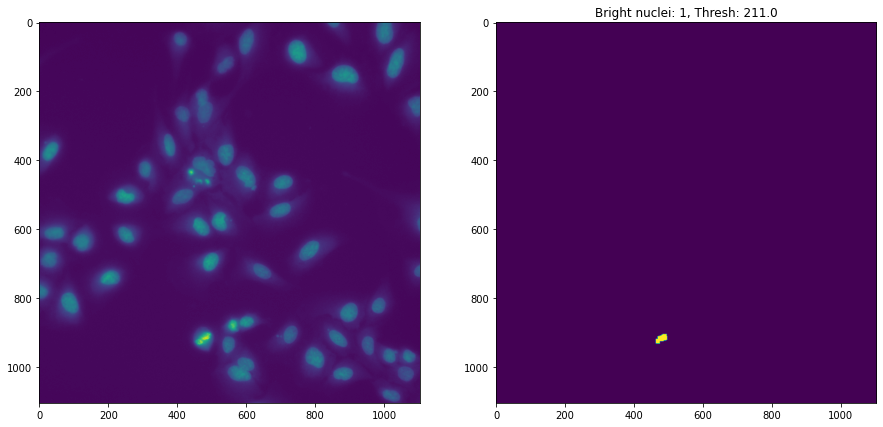

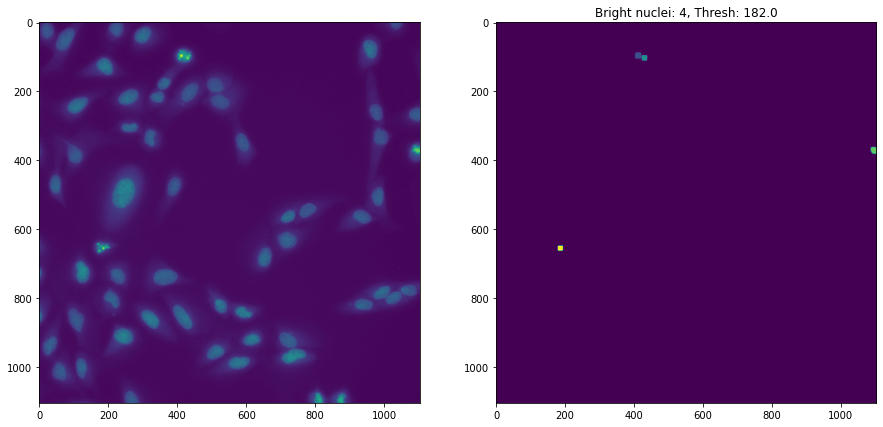

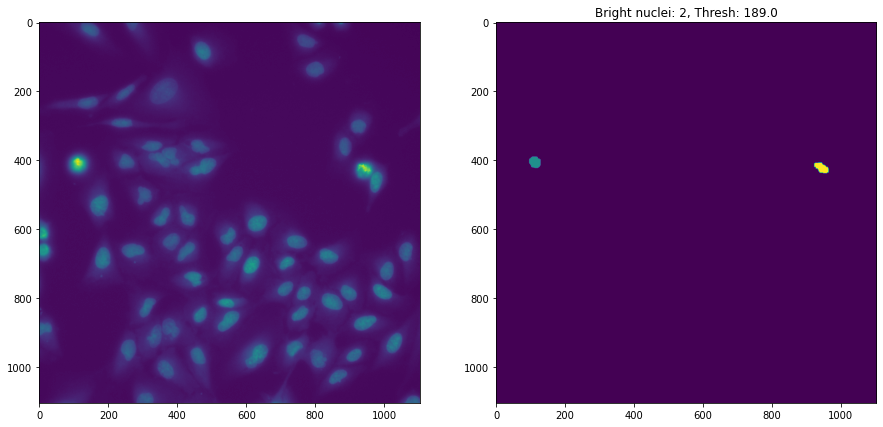

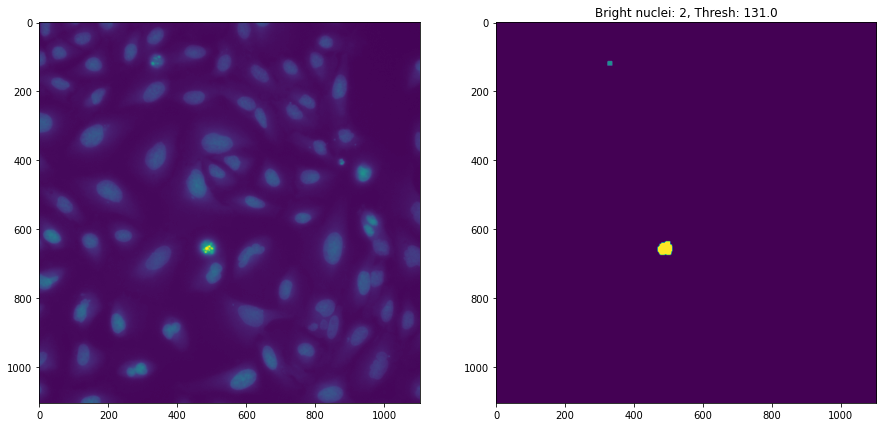

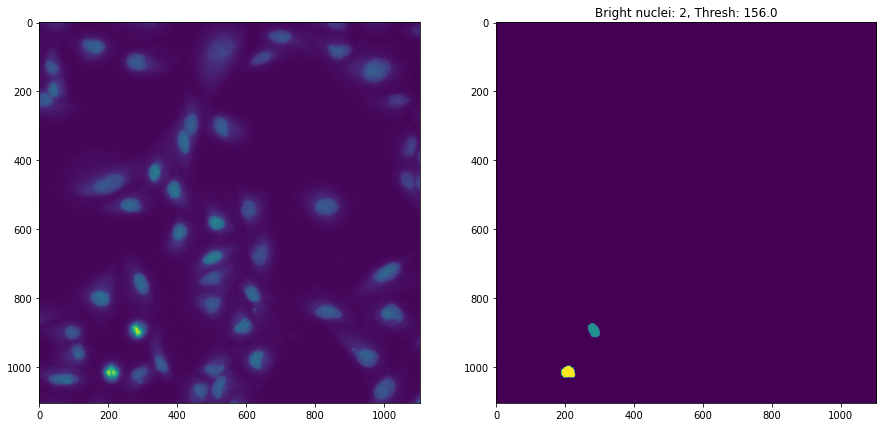

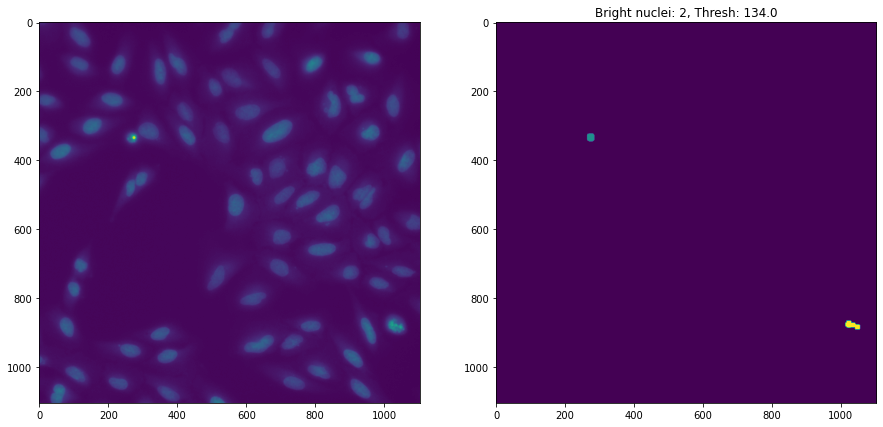

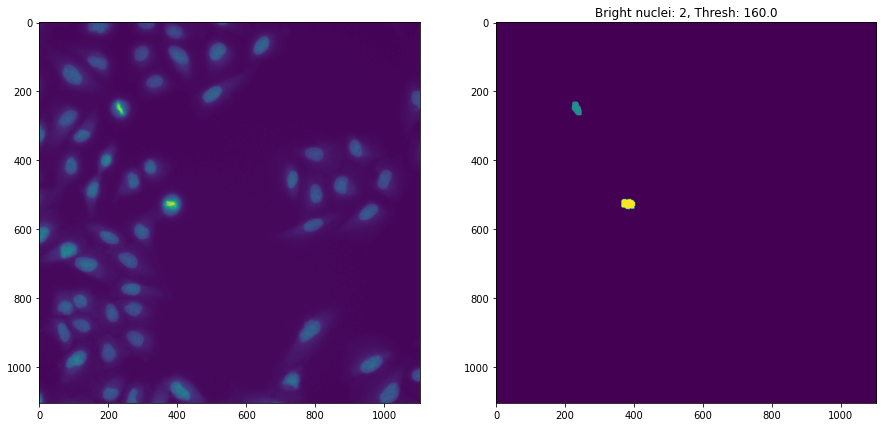

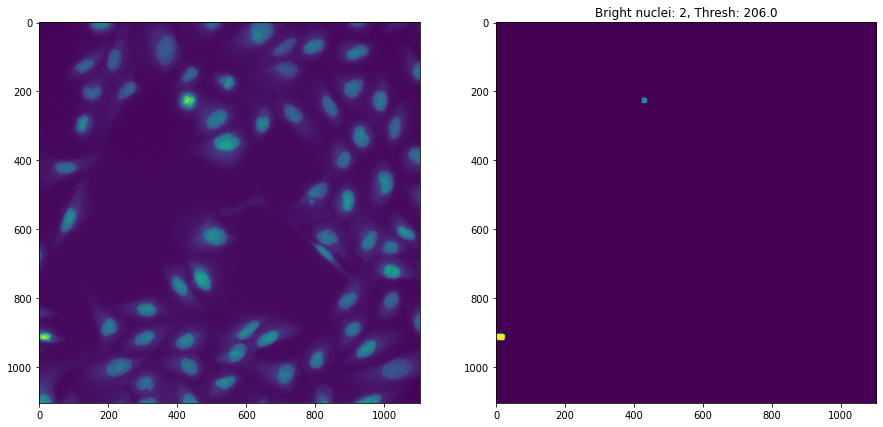

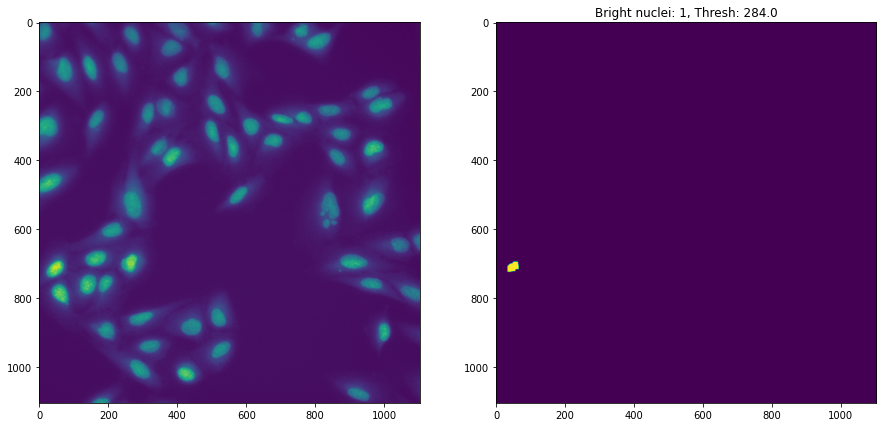

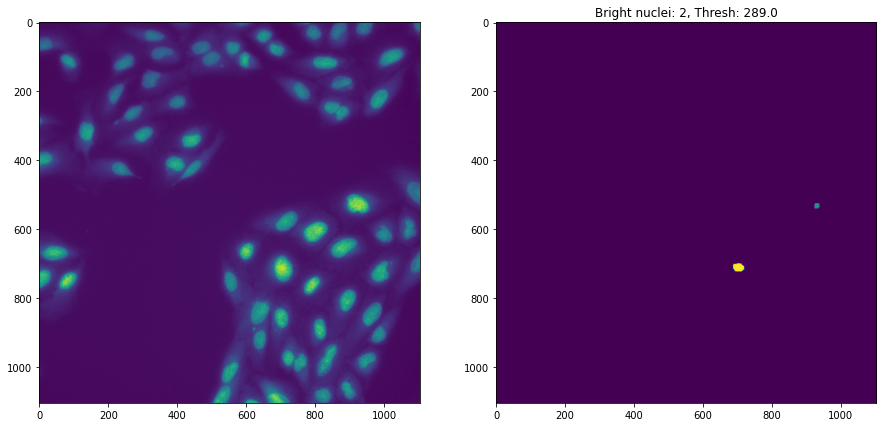

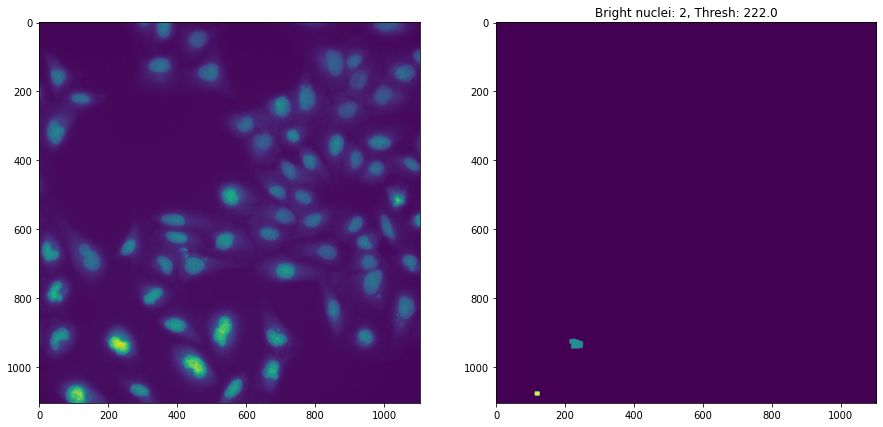

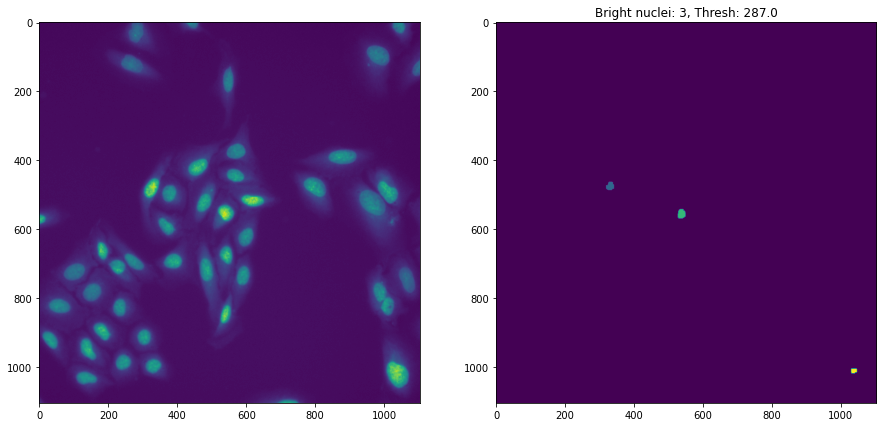

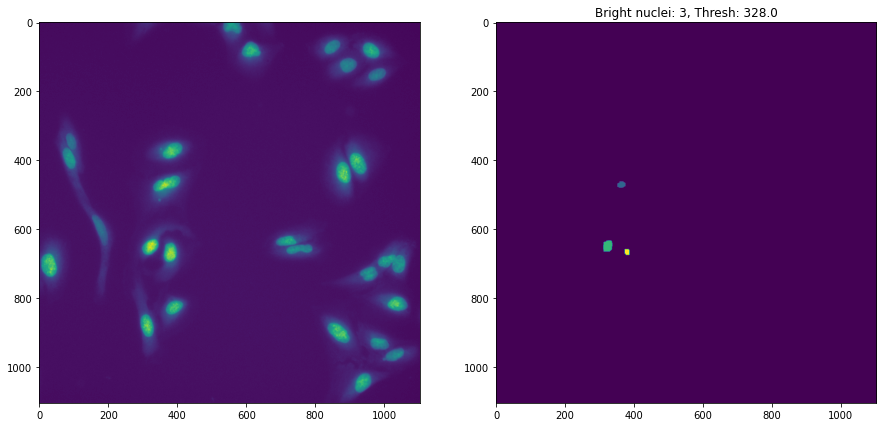

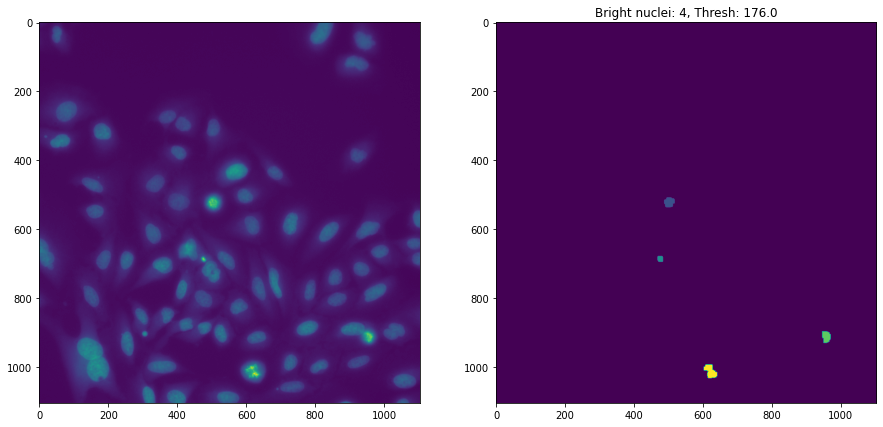

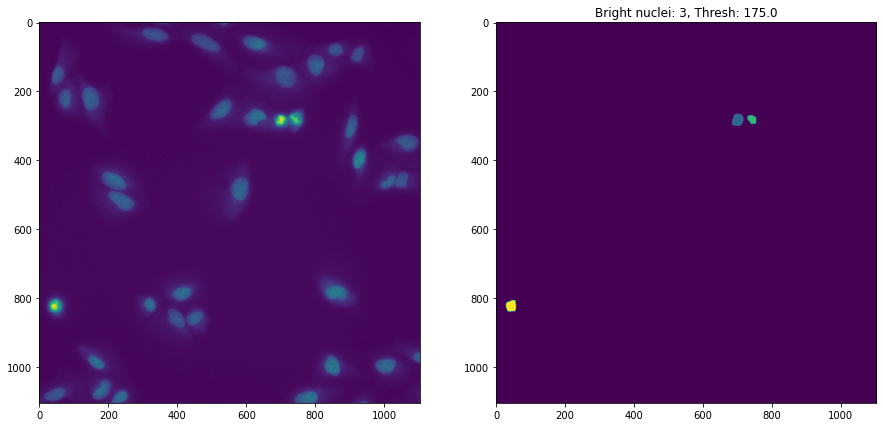

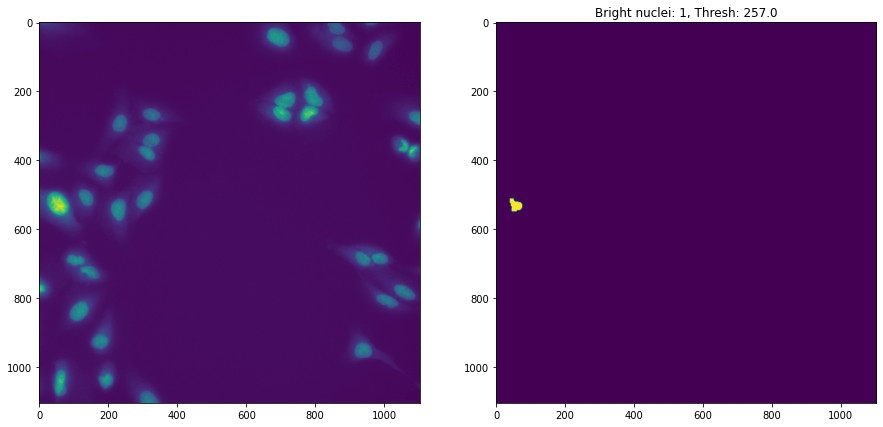

In [4]:
for image in testset:
    
    im = skimage.io.imread(mock + image)
    #im = normalize(im)
    prob = skimage.io.imread(mockpred + image)
    pred = probmap_to_pred(prob,1)
    label = pred_to_label(pred,100)
    # make labels...#

    
    avg_intens = get_nuclei_intensity(im, label)
    
    fig,ax = plt.subplots(1,2,figsize=(15,10))
    ax[0].imshow(im)
    

    bright = np.zeros(im.shape)
    bright[im > (min(2.4*avg_intens, 220))] = 255
    # Increase size of objects
    bright = img_as_bool(bright)
    bright = skimage.morphology.remove_small_objects(bright, min_size=10)
    struct = skimage.morphology.square(10)
    bright = skimage.morphology.dilation(bright, struct)

    bright = skimage.morphology.label(bright)
    count = len(np.unique(bright))-1

    ax[1].imshow(bright)
    ax[1].set_title("Bright nuclei: " + str(count) + ", Thresh: " + str(round(2.4*avg_intens,0)))
    #ax[1].imshow(label)
    #ax[2].imshow(bright)
    plt.show()